# Backtesting a Random Forest

### MGMT 767 / BUSI 449: Data-Driven Investments: Equity
### Kerry Back and Kevin Crotty, Rice University

# Overview of Backtesting

- The goal is to illustrate the process of evaluating a model for combining characteristics to predict stock returns.
- A model has parameters (coefficients) that must be estimated from past data.
- It may also have hyperparameters that should be tuned from past data (more later).
- If we wanted to apply a model today, we would use all past data to estimate the parameters.  Then look at today's characteristic values and run them through the model to predict returns.


- To evaluate how a model would have worked in the past, we should recreate this at each past portfolio revision date:
  - Estimate the parameters based on the data prior to that date.
  - Look at the characteristic values at that date and run them through the model to predict returns.
  - Form a portfolio based on the predictions.
  - Calculate the return of the portfolio up to the next portfolio revision date.
  - Rinse and repeat.

### Examples of models

- Linear regression
- Penalized linear regression (LASSO, ridge regression, elastic net)
- Random forests
- Boosted trees
- Neural networks

# Introduction to Random Forests

### Random forest

- From your data set, generate random "pseudo data sets" by bootstrapping.
  - Randomly choose rows from the original set with replacement until you have as many rows as in the original.
  - Do this, say, 100 times, to create 100 pseudo data sets.
- Fit a decision tree (more coming) to each pseudo data sets.
- Average the predictions from the 100 decision trees.

### Decision tree example

- Generate some simple random data: predictors $x_1$ and $x_2$ and outcome $y$
- Fit a decision tree to predict $y$ from $x_1$ and $x_2$.

In [2]:
import numpy as np 
import pandas as pd

np.random.seed(0)
x1 = np.random.normal(size=100)
x2 = np.random.normal(size=100)
e = np.random.normal(size=100)
y = 2*x1 + 3*x2 + e
df = pd.DataFrame(
    dict(x1=x1, x2=x2, y=y)
)

In [3]:
df

,x1,x2,y
0,1.764052,1.883151,8.808375
1,0.400157,-1.347759,-3.482342
2,0.978738,-1.270485,-0.754319
3,2.240893,0.969397,8.045240
4,1.867558,-1.173123,0.855877
...,...,...,...
95,0.706573,-0.171546,2.035399
96,0.010500,0.771791,2.434097
97,1.785870,0.823504,6.625207
98,0.126912,2.163236,6.344083


### Fit and view a decision tree

In [4]:
from sklearn.tree import DecisionTreeRegressor, plot_tree 
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X=df[["x1", "x2"]], y=df.y)

DecisionTreeRegressor(max_depth=3)

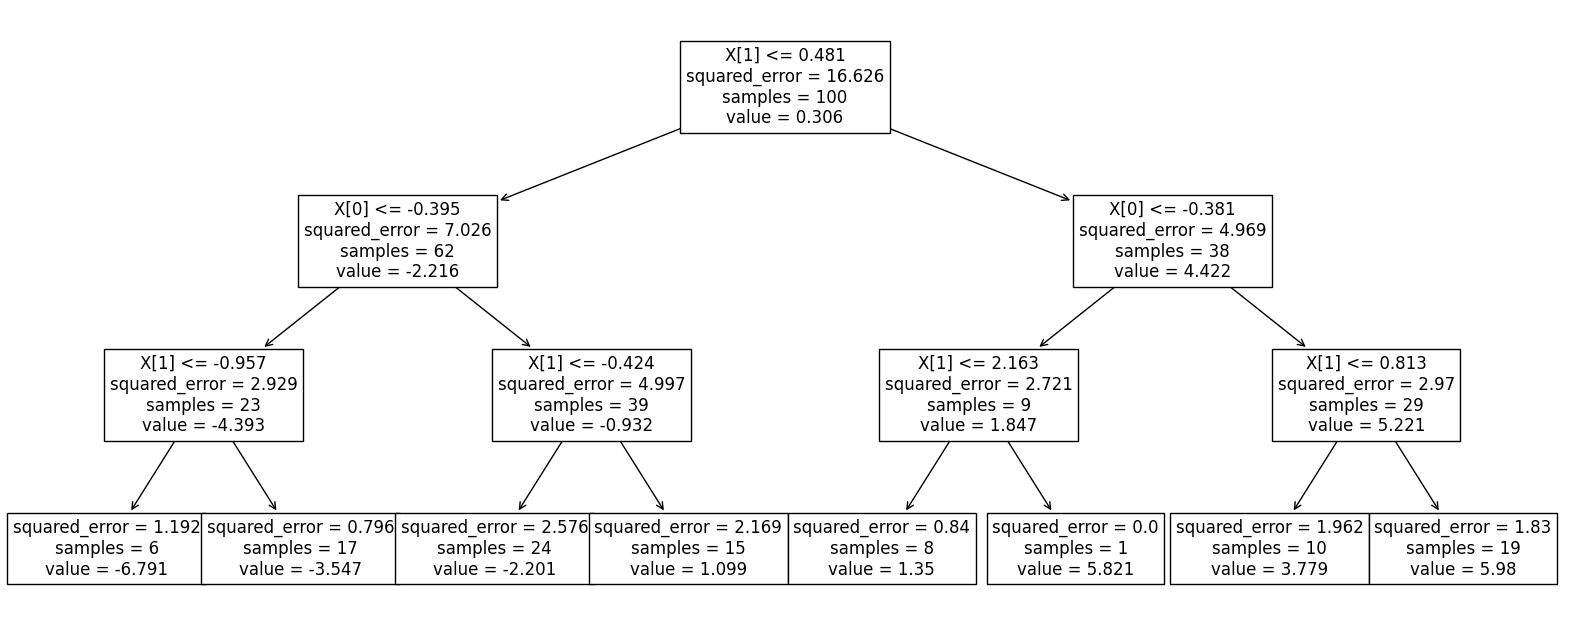

In [5]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20, 8))
plot_tree(tree, fontsize=12)
plt.show()

### Fit a random forest and view goodness of fit

In [6]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=3)
forest.fit(X=df[["x1", "x2"]], y=df.y)
predict = forest.predict(X=df[["x1", "x2"]])

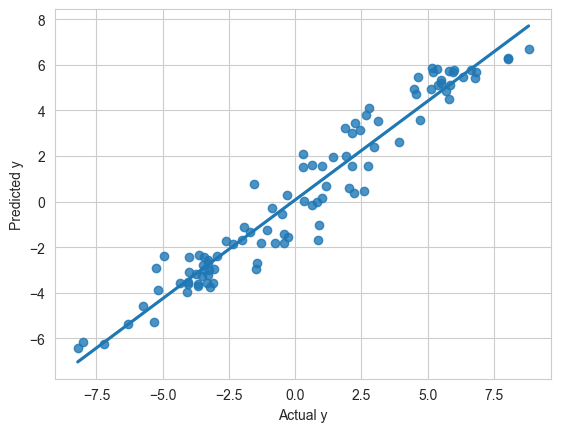

In [7]:
import seaborn as sns 
sns.set_style("whitegrid")

sns.regplot(x=df.y, y=predict, ci=None)
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.show()

# Data for Backtesting Example

In [9]:
df = pd.read_csv("02_data.csv", index_col=["ticker", "date"])
""" 
df = pd.read_csv(
    "https://www.dropbox.com/s/km8tb71md3a5m1r/02_data.csv?dl=1",
    index_col=["ticker", "date"]
)
"""
df.head()

pb  marketcap lastupdated  close       ret       mom
ticker date                                                             
AA     2019-08-23  0.7     3436.5  2019-08-19  18.52 -0.015660 -0.434685
       2019-08-30  0.7     3382.7  2019-08-27  18.23 -0.058148 -0.451343
       2019-09-06  0.7     3186.0  2019-09-04  17.17  0.025635 -0.472985
       2019-09-13  0.7     3267.7  2019-09-09  17.61  0.281083 -0.535282
       2019-12-06  0.8     3793.1  2019-12-02  20.44 -0.033275 -0.359533

### Relative predictors and returns

- To control for variation over time in levels of predictors, use deviations from medians.
- We want to predict relative performance (which stocks will do better than others), so use deviation from median return as the target.

In [9]:
for col in ["mom", "pb", "ret"]:
    df[col+"_adjusted"] = df.groupby("date", group_keys=False)[col].apply(
        lambda x: x - x.median()
    )

# Backtest Random Forest

### Overview

- max_depth is a hyperparameter that we could "tune," but today just try max_depth=2
- For speed, train only once per year.
- Use trained model to make predictions weekly.
- Pick best 50 stocks each week and hold equally weighted until end of week.
- Repeat until end of year.
- Then retrain and repeat.
- First, make some changes to the dataframe (put date and ticker in columns, add year, and sort).

In [10]:
df = df.reset_index()
df["date"] = pd.to_datetime(df.date)
df["year"] = df.date.map(lambda x: x.year)
df = df.sort_values(by=["date", "ticker"])

In [11]:
df2 = None 
forest = RandomForestRegressor(max_depth=2)

for year in range(2014, 2024):
    print(year)
    start = df[df.year == year].date.min()
    past = df[df.date < start]
    future = df[df.year == year].copy()
    forest.fit(X=past[["mom_adjusted", "pb_adjusted"]], y=past["ret_adjusted"])
    future["predict"] = forest.predict(X=future[["mom_adjusted", "pb_adjusted"]])
    df2 = pd.concat((df2, future))

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [12]:
df2.head()

,ticker,date,pb,marketcap,lastupdated,close,ret,mom,mom_adjusted,pb_adjusted,ret_adjusted,year,predict
811,AAIC,2014-01-03,0.9,455.6,2020-10-26,27.44,-0.018456,0.395965,0.079050,-0.9,-0.018832,2014,0.002582
1136,AAMC,2014-01-03,582.3,2050.2,2023-11-01,902.00,0.025155,8.951573,8.634657,580.5,0.024779,2014,0.000755
2357,AAON,2014-01-03,7.4,1202.4,2023-08-17,32.72,-0.031758,1.180593,0.863678,5.6,-0.032134,2014,0.001834
3080,AAT,2014-01-03,1.9,1269.7,2018-10-18,31.39,0.015607,0.184788,-0.132128,0.1,0.015231,2014,0.001802
4052,AAWW,2014-01-03,0.8,1011.3,2018-10-18,40.39,0.019064,-0.172344,-0.489259,-1.0,0.018688,2014,0.000053


### 50 best stocks each week

In [14]:
starting_from_best = df2.groupby(
    "date", 
    group_keys=False
).predict.rank(
    ascending=False, 
    method="first"
)
best = df2[starting_from_best <= 50]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

### Worst stocks and all stocks

In [15]:
starting_from_worst = df2.groupby(
    "date", 
    group_keys=False
).predict.rank(
    ascending=True, 
    method="first"
)

worst = df2[starting_from_worst <= 50]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

all_rets = df2.groupby("date", group_keys=True).ret.mean()
all_rets.index = pd.to_datetime(all_rets.index)

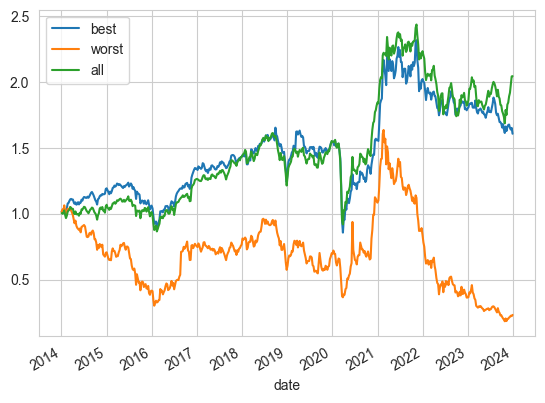

In [16]:
(1+best_rets).cumprod().plot(label="best")
(1+worst_rets).cumprod().plot(label="worst")
(1+all_rets).cumprod().plot(label="all")
plt.legend()
plt.show()